In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import rasterio as rio
import functions as f
import xarray as xr
from importlib import reload
import os

10it [02:34, 15.48s/it]


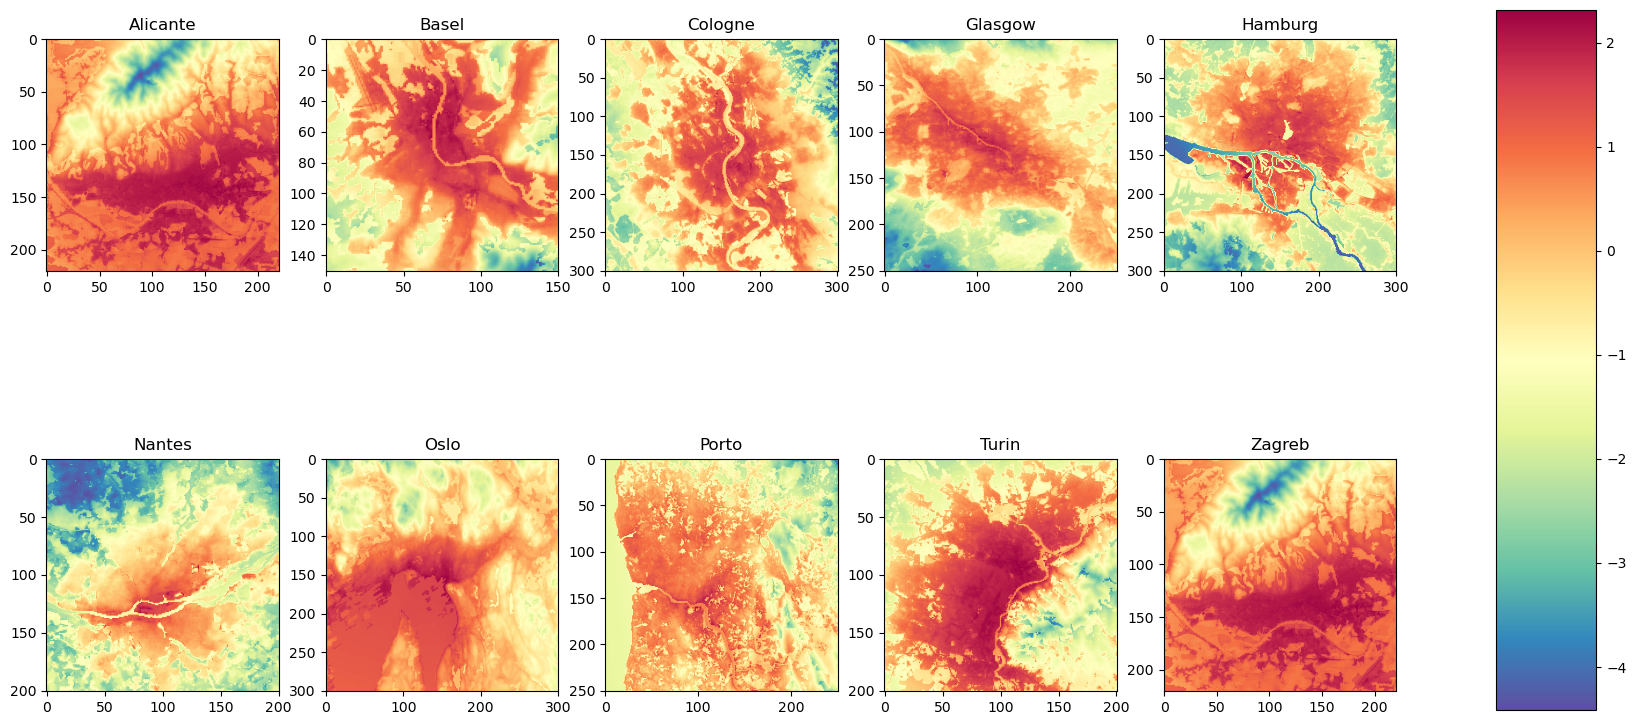

In [84]:
reload(f)

# Data visualization

f.plot_avg_deltaT('data')

In [24]:

#Reprojection of the elevation raster in the good crs
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd

# Set the paths to your input and output raster files
input_raster_path = "elevation\eea_r_4326_1_km_elevation-map-europe_p_2004_v01_r00\elevationeurope1x1.tif"
output_raster_path = "elevation\eea_r_4326_1_km_elevation-map-europe_p_2004_v01_r00\elevationeurope1x1_reproj2.tif"
'''
input_raster_path_lc = "MCD12Q1.061_LC_Prop1_doy2011001_aid0001.tif"
output_raster_path_lc = "MCD12Q1.061_LC_Prop1_doy2011001_aid0001_reproj.tif"'''

# Set the desired CRS
target_crs = "EPSG:3035"  # Change this to the CRS you want

# Read the input raster file
with rasterio.open(input_raster_path) as src:
    # Define the transformation settings
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds
    )

    # Update metadata
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create the output raster file
    with rasterio.open(output_raster_path, 'w', **kwargs) as dst:
        # Reproject the data
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest  # You can choose a different resampling method if needed
            )

In [6]:
#open the GTiff file with rasterio

#reload(f)


pop_day_europe = rio.open(r'data_population_day\ENACT_POP_D072011_EU28_R2020A_4326_30ss_V1_0.tif')
pop_night_europe = rio.open(r'data_night_30ss\ENACT_POP_N072011_EU28_R2020A_4326_30ss_V1_0.tif')
elevation = rio.open(r"elevation\eea_r_4326_1_km_elevation-map-europe_p_2004_v01_r00\elevationeurope1x1_reproj2.tif")
land_cover = rio.open(r"MCD12Q1.061_LC_Prop1_doy2011001_aid0001.tif")
folder = 'data'

#When selecting the data, make attnetion to the presence of mountains around (or we have to find the elevation data and add it)

#df = f.process_data(folder, pop_day_europe, pop_night_europe, elevation, land_cover, 500000)


In [8]:
df = f.process_data_city(folder, pop_day_europe, pop_night_europe, elevation, land_cover, 500000, 'Nantes')

AttributeError: 'Dataset' object has no attribute 'shape'

In [1]:
reload(f)
nts_tas = xr.open_dataset(r'data\tas_Nantes_UrbClim_2011_07_v1.0.nc')

cropped1, cropped2, down_nts_tas= f.crop_and_downgrade(pop_day_europe, pop_night_europe, nts_tas)

#reverse y array of down tas nts
down_nts_tas = down_nts_tas.reindex(y=down_nts_tas.y[::-1])
plt.imshow(cropped1, cmap='Spectral_r')

NameError: name 'reload' is not defined

In [4]:
df

,temp,pop,wind,hum,deltaT,hour,city,elevation,isrural,land cover type,latitude,longitude
0,287.049805,69.338377,1.788839,89.764030,-0.365906,8,Basel,90.0,1.0,31.0,47.531345,7.514861
1,287.130585,135.332663,0.893652,67.229408,2.161499,3,Basel,93.0,NaN,22.0,47.554070,7.564253
2,293.552032,-200.000000,0.010000,59.368694,0.812317,17,Basel,102.0,NaN,31.0,47.605850,7.544520
3,289.507172,1125.632124,1.277240,84.997215,0.481598,0,Basel,92.0,NaN,22.0,47.533558,7.573188
4,292.701447,1617.425752,2.407799,45.471851,1.133148,17,Basel,109.0,NaN,22.0,47.529987,7.657013
...,...,...,...,...,...,...,...,...,...,...,...,...
499995,290.983276,-200.000000,1.218446,48.316753,-0.295197,9,Oslo,74.0,1.0,15.0,59.802311,10.961075
499996,293.706421,-200.000000,0.938246,64.413956,-0.696259,15,Oslo,78.0,NaN,22.0,59.805187,10.607456
499997,288.039337,-200.000000,1.631753,98.782509,-0.280060,7,Oslo,0.0,1.0,3.0,60.011547,10.537845
499998,292.421906,-200.000000,1.439674,66.654488,0.041534,18,Oslo,1.0,1.0,3.0,59.976559,10.508708


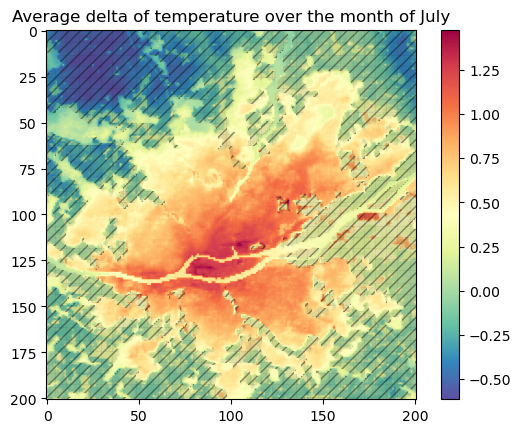

In [17]:
'''#import patches
from matplotlib import patches

#group by pixel number and compute the mean of temp_delta
data_df_mean_dt = data_df_aug.groupby(['pixel_number']).mean()


#reshape the dataframe into a 201x201 image and plot it
data_df_mean_dt = data_df_mean_dt.temp_delta.values.reshape(201,201)
data_df_mean_dt = np.flipud(data_df_mean_dt)

data_urban_mask = data_urban.urban.values.reshape(201,201)
data_urban_mask = np.flipud(data_urban_mask)

plt.imshow(data_df_mean_dt, cmap='Spectral_r')
plt.colorbar()
plt.imshow(data_urban_mask, cmap='gray', alpha=0)
ax = plt.gca()
for p in range(201):
    for q in range(201):
        if data_urban_mask[p,q] == 1:
            ax.add_patch(patches.Rectangle((q,p),1,1, fill=False, lw = 0.1, hatch='///', alpha=0.4))


plt.title('Average delta of temperature over the month of July')
plt.show()
'''

# Data processing

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
scaler = StandardScaler()
le.fit(df.city)
df_sampled = df.sample(200000)
df_sampled.fillna(0, inplace=True)
df_sampled = df_sampled[df_sampled['isrural'] == 0]
df_sampled['city'] = le.transform(df_sampled['city'])
#df_sampled[['temp', 'pop', 'wind', 'hum']] = scaler.fit_transform(df_sampled[['temp', 'pop', 'wind', 'hum']])
#create a categorical variable for the city variable
X = df_sampled.drop(['deltaT', 'city', 'isrural'], axis=1)
y = df_sampled.deltaT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

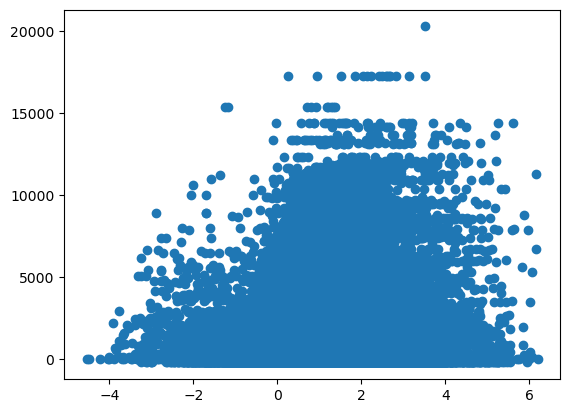

In [68]:
plt.scatter(y_train, X_train['pop'])

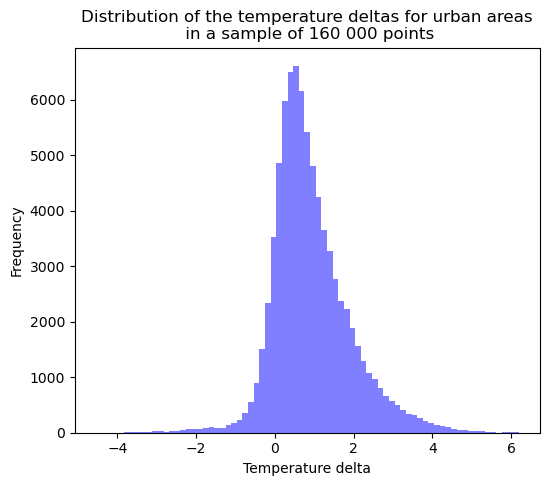

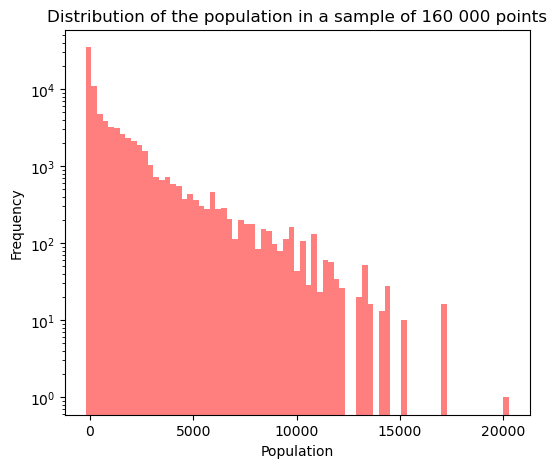

In [27]:
reload(f)
fig = plt.figure(figsize=(6,5))
plt.hist(y_train, bins=75, color='blue', alpha=0.5, label='train')
plt.title('Distribution of the temperature deltas for urban areas\n in a sample of 160 000 points')
plt.xlabel('Temperature delta')
plt.ylabel('Frequency')
plt.show()

fig = plt.figure(figsize=(6,5))
plt.hist(X_train['pop'], bins=75, color='red', alpha=0.5, label='test', log=True)
plt.title('Distribution of the population in a sample of 160 000 points')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.show()

# Linear regression

This is the most basic form of regression. It is used to predict a quantitative response Y from the predictor variable X.

MSE: 0.846504558973639
R2 score: 0.15362739891979837
Intercept: 14.24179219277887 
Coefficients: [-4.51680966e-02  5.98306147e-05 -1.83805762e-01 -1.37825358e-02
 -6.04116026e-03  4.34485607e-03 -7.33807374e-03  1.85422441e-02
  1.21726627e-02]


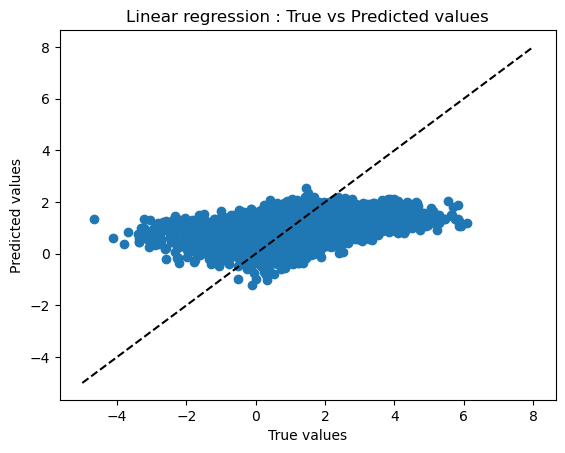

In [36]:
from sklearn.linear_model import LinearRegression

# Create an instance of LinearRegression
lr = LinearRegression()

# Fit the model with the training data
lr.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = lr.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('R2 score:', r2)

print('Intercept:', lr.intercept_, '\nCoefficients:', lr.coef_)

plt.scatter(y_test, y_pred)
plt.plot([-5, 8], [-5, 8], 'k--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Linear regression : True vs Predicted values')
plt.show()


# Ridge regression

Ridge regression is a technique used when the data suffers from multicollinearity (independent variables are highly correlated). In multicollinearity, even though the least squares estimates (OLS) are unbiased, their variances are large which deviates the observed value far from the true value. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors.

MSE: 0.8465045775109818
R2 score: 0.1536273803853453
Intercept: 14.241739089558656 
Coefficients: [-4.51679365e-02  5.98306518e-05 -1.83803964e-01 -1.37825312e-02
 -6.04119969e-03  4.34487525e-03 -7.33804515e-03  1.85423048e-02
  1.21725265e-02]


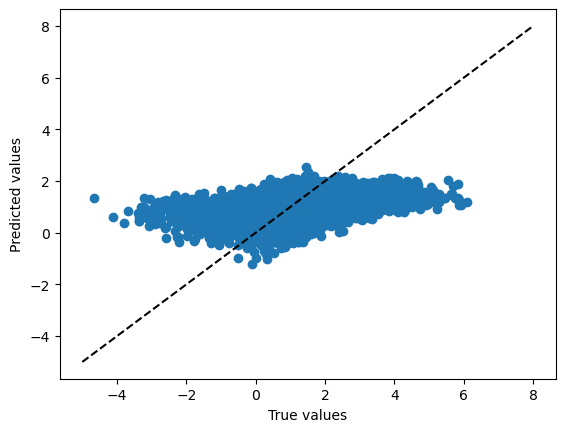

In [40]:
from sklearn.linear_model import Ridge

# Create an instance of Ridge regression
ridge = Ridge(alpha=1)

# Fit the model with the training data
ridge.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = ridge.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('R2 score:', r2)

print('Intercept:', ridge.intercept_, '\nCoefficients:', ridge.coef_)

plt.scatter(y_test, y_pred)
plt.plot([-5, 8], [-5, 8], 'k--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()

# Multi-layer Perceptron regressor

MLP are a category of machine learning algorithm consisting in at least 3 layers of fully interconnected neurons. Learning occurs by changing the connection weights base on the error between the predicted and the actual output. The backpropagation algorithm is used to calculate the error and update the weights. The major disadvantage of MLP is that it is very computationally expensive to train. Here is a schema of an MLP regressor from Skiba (2020)
<p align="center">
  <img src="Example-of-multilayer-perceptron-MLP-network-for-regression-analysis-here-n-13-and.png" />
</p>


In [ ]:
#Implement MLP regressor
from sklearn.neural_network import MLPRegressor


mlp = MLPRegressor(max_iter=1000, hidden_layer_sizes=(10,10,10), activation='relu', verbose=True)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)



MSE:  0.43359015418502905
R2 score:  0.5664774362877628


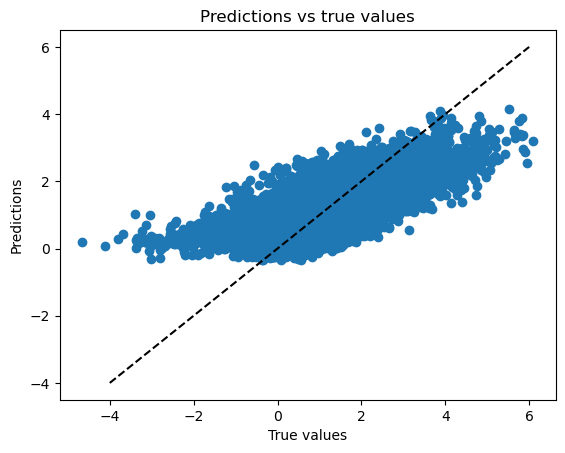

In [48]:
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2 score: ', r2_score(y_test, y_pred))


#plot the predictions vs the true values
plt.scatter(y_test, y_pred)
plt.plot([-4, 6], [-4, 6], 'k--')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('Predictions vs true values')
plt.show()

# Random forest regressor

Random forest regressor is a powerful algorithm to perform a reression. It consits in fitting a number of classifying decision trees on subsamples of the dataset and averaging the decision of each tree to obtain a prediction. The main parameters to tune are the number of trees in the forest and the number of features to consider when looking for the best split. Here is schema of a random tree algorithm (Vo Thanh Ha (2023))

<p align="center">
  <img src="Structure-of-random-forest-regressor-algorithm-The-Random-Forest-Regressor-model-is.png" />
</p>



MSE:  0.2715819212279097
R2:  0.7284604144900035


Text(0, 0.5, 'Predicted values')

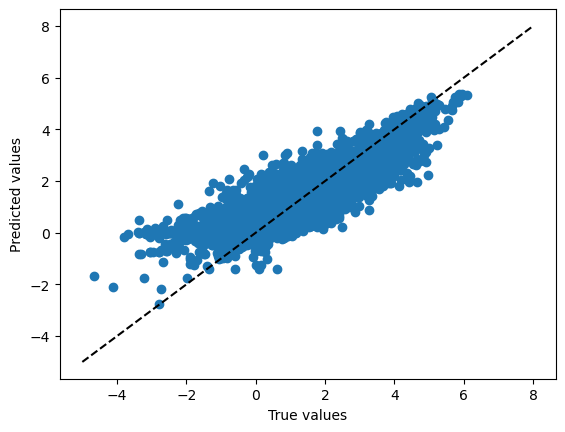

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


rf = RandomForestRegressor(n_estimators=100, max_depth=25   , bootstrap=True, criterion='squared_error')
                                                       
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mean_squared_error(y_test, y_pred)
r2_score(y_test, y_pred)

print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.plot([-5, 8], [-5, 8], 'k--')
plt.xlabel('True values')
plt.ylabel('Predicted values')


# Extra Trees regressor

ETR, also known as _Extremely randomized trees_, described in Geurts et al. (2006), is a modified version of the random forest tree regressor with two substantial changes
- The samples subset and a subset of the feature set are selected randomly for each tree
- To select a splitting point, a random value is selected instead of computing a locally optimal value

Thess two 'randomifications' of the random forest algorithm allows a reduction of the overfitting of the model, and thus a better generalization of the model.

here is a schema that summarize the process for a classification ET. For a regressor, the process is the same, except that, in the end, the average of predicted value is chosen (Kapoor 2020)

<p align="center">
  <img src="Structure-of-Extra-Trees-Kapoor-2020-Extra-Trees-constructs-the-set-of-decision-trees.png" />
</p>


the mse is :  0.13787207751051808
the r2 score is :  0.8621494147646496


Text(0, 0.5, 'Predicted values')

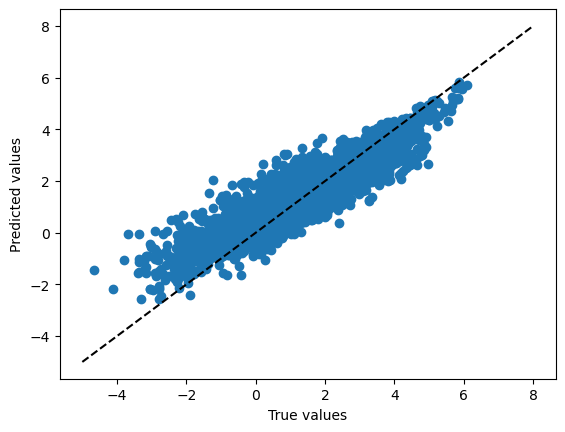

In [51]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm import tqdm


etr = ExtraTreesRegressor(n_estimators=100, max_depth=25)

# Fit the model with the training data
etr.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = etr.predict(X_test)



'''fig, ax = plt.subplots(1,2, figsize=(10,5))
plt.suptitle('Extra Trees Regressor performance')
ax[0].plot(range(10, 20), mse)
ax[0].set_xlabel('Number of trees')
ax[0].set_ylabel('MSE')
ax[1].plot(range(10, 20), r2)
ax[1].set_xlabel('Number of trees')
ax[1].set_ylabel('R2 score')
plt.show()'''

# Evaluate the model performance
print('the mse is : ',mean_squared_error(y_test, y_pred))
print('the r2 score is : ',r2_score(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.plot([-5, 8], [-5, 8], 'k--')
plt.xlabel('True values')
plt.ylabel('Predicted values')


In [64]:
df_test = f.process_data_city('data', pop_day_europe, pop_night_europe, elevation, land_cover, 500, 'Oslo')

df_sample_test = df_test.sample(500)
y_pred_test = etr.predict(df_sample_test.drop(['deltaT', 'city', 'isrural'], axis=1))



(67407144,) (67407144,)


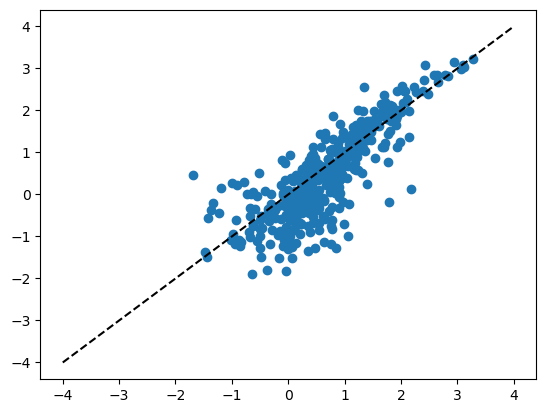

In [65]:
plt.scatter(y_pred_test, df_sample_test['deltaT'])
plt.plot([-4, 4], [-4, 4], 'k--')

In [ ]:
'''reload(f)

mse = round(mean_squared_error(y_test, y_pred),3)
r2 = round(r2_score(y_test, y_pred),3)
fig = plt.figure()
f.using_mpl_scatter_density(fig, y_pred, y_test)
plt.plot([-5, 8], [-5, 8], 'k--', alpha=0.5)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.xlim(-4, 6)
plt.ylim(-4, 6)
plt.title('Extra Trees Regressor\n Mean squared error: '+str(mse)+'\n R2 score: '+str(r2))

plt.show()'''

# Gradient Boosting regressor

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. The sklearn histGradientBoostingRegressor is based on the LightGBM method that uses an histogram based method to bin the features, therefore using less memory and being faster than the classical gradient boosting method. Here is a schema of the gradient boosting algorithm.
<p align="center">
  <img src="Flow-diagram-of-gradient-boosting-machine-learning-method-The-ensemble-classifiers.png" />
</p>


MSE: 0.23761389401886426
R2 score: 0.7511460624337648


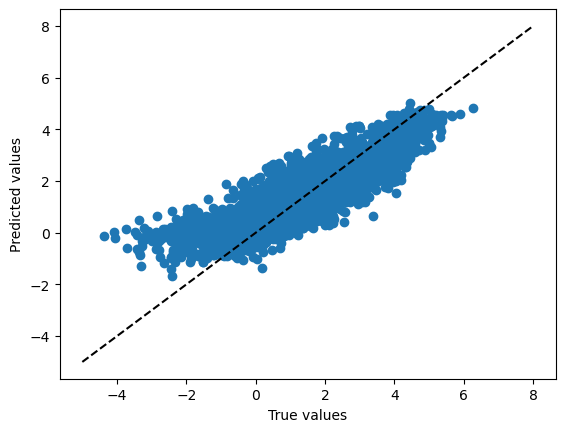

In [42]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Create an instance of HistGradientBoostingRegressor
gb = HistGradientBoostingRegressor()

# Fit the model with the training data
gb.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = gb.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('R2 score:', r2)

plt.scatter(y_test, y_pred)
plt.plot([-5, 8], [-5, 8], 'k--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()

# K-nearest neighbors regressor

KNN regression is one of the simplest algorithm. It consists in finding the K nearest neighbors of a point and then interpolating their values to obtain a prediction. The main parameter to tune is the number of neighbors to consider. Here is a schema of the KNN algorithm. For a low number of data it's very fast

MSE: 0.4854598028762183
R2 score: 0.49157609669793023


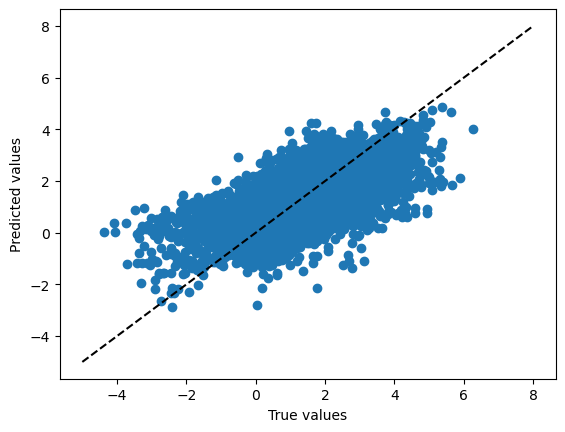

In [51]:
from sklearn.neighbors import KNeighborsRegressor

# Create an instance of KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=4, weights='distance')

# Fit the model with the training data
knn.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = knn.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('R2 score:', r2)

plt.scatter(y_test, y_pred)
plt.plot([-5, 8], [-5, 8], 'k--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()


In [107]:
reload(f)
zagreb_df = f.process_data_city('data', pop_day_europe, pop_night_europe, elevation, land_cover, 10000, 'Basel')
zagreb_df

(16963944,) (16963944,)


,temp,pop,wind,hum,deltaT,hour,elevation,isrural,land cover type,city,latitude,longitude
0,291.651550,5895.744101,1.777558,74.773705,-0.102814,13,104.0,1.0,22.0,Basel,47.511997,7.657828
1,291.385712,1155.519528,1.173908,67.765495,0.927521,10,90.0,NaN,22.0,Basel,47.505653,7.614316
2,293.316986,-200.000000,1.419290,77.001526,0.445923,17,104.0,1.0,22.0,Basel,47.580547,7.540407
3,285.866394,-200.000000,1.346292,92.605377,-0.468109,3,127.0,1.0,14.0,Basel,47.625950,7.639351
4,286.983704,-200.000000,0.662057,86.997063,-0.079834,23,102.0,1.0,31.0,Basel,47.626087,7.523600
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,298.111053,93.560754,1.042723,29.025471,3.742554,22,88.0,NaN,22.0,Basel,47.543140,7.599303
9996,287.165588,0.051673,1.201782,81.060814,-0.332642,16,89.0,1.0,22.0,Basel,47.565853,7.650072
9997,289.602081,-200.000000,0.010000,83.798836,0.196625,1,100.0,1.0,22.0,Basel,47.628910,7.609946
9998,298.045074,994.526464,1.619557,36.923607,-0.689331,11,109.0,1.0,22.0,Basel,47.576485,7.684143
